## 2층 신경망 구현

In [1]:
# coding: utf-8
import sys, os

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.functions import *
from common.gradient import numerical_gradient


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params["W1"] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params["b1"] = np.zeros(hidden_size)
        self.params["W2"] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params["b2"] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params["W1"], self.params["W2"]
        b1, b2 = self.params["b1"], self.params["b2"]

        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)

        return y

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)

        return cross_entropy_error(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads["W1"] = numerical_gradient(loss_W, self.params["W1"])
        grads["b1"] = numerical_gradient(loss_W, self.params["b1"])
        grads["W2"] = numerical_gradient(loss_W, self.params["W2"])
        grads["b2"] = numerical_gradient(loss_W, self.params["b2"])

        return grads

    def gradient(self, x, t):
        W1, W2 = self.params["W1"], self.params["W2"]
        b1, b2 = self.params["b1"], self.params["b2"]
        grads = {}

        batch_num = x.shape[0]

        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)

        # backward
        dy = (y - t) / batch_num
        grads["W2"] = np.dot(z1.T, dy)
        grads["b2"] = np.sum(dy, axis=0)

        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads["W1"] = np.dot(x.T, dz1)
        grads["b1"] = np.sum(dz1, axis=0)

        return grads

## 미니베치 학습 구현

train acc, test acc | 0.09736666666666667, 0.0982
train acc, test acc | 0.7806166666666666, 0.7896
train acc, test acc | 0.8765166666666667, 0.8821
train acc, test acc | 0.8989166666666667, 0.903
train acc, test acc | 0.90775, 0.9097
train acc, test acc | 0.9137833333333333, 0.9177
train acc, test acc | 0.9195833333333333, 0.9218
train acc, test acc | 0.9236, 0.9238
train acc, test acc | 0.9278833333333333, 0.9279
train acc, test acc | 0.9311, 0.9314
train acc, test acc | 0.9344166666666667, 0.9347
train acc, test acc | 0.93655, 0.9355
train acc, test acc | 0.9394, 0.9382
train acc, test acc | 0.9415333333333333, 0.9409
train acc, test acc | 0.9439, 0.9425
train acc, test acc | 0.9456333333333333, 0.9442
train acc, test acc | 0.9473833333333334, 0.9467


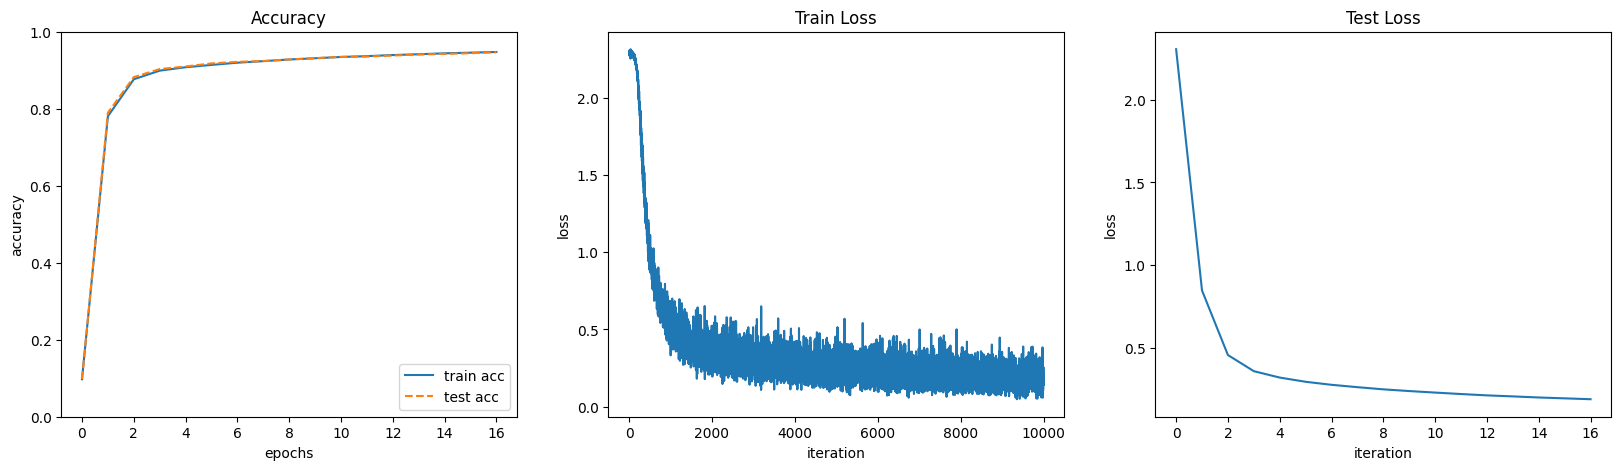

In [5]:
# coding: utf-8
import sys, os

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100  # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    # grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)

    # 매개변수 갱신
    for key in ("W1", "b1", "W2", "b2"):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        test_loss = network.loss(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        test_loss_list.append(test_loss)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {"train": "o", "test": "s"}
plt.figure(figsize=(20, 5))
x = np.arange(len(train_acc_list))
plt.subplot(1, 3, 1)
plt.plot(x, train_acc_list, label="train acc")
plt.plot(x, test_acc_list, label="test acc", linestyle="--")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc="lower right")
plt.title("Accuracy")
plt.subplot(1, 3, 2)
plt.plot(np.arange(len(train_loss_list)), train_loss_list, label="train loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("Train Loss")
plt.subplot(1, 3, 3)
plt.plot(np.arange(len(test_loss_list)), test_loss_list, label="test loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("Test Loss")
plt.show()